Number of samples: 3680
Extracting classes... (be patient)


100%|██████████| 3680/3680 [00:15<00:00, 242.69it/s]


Number of unique classes: 37


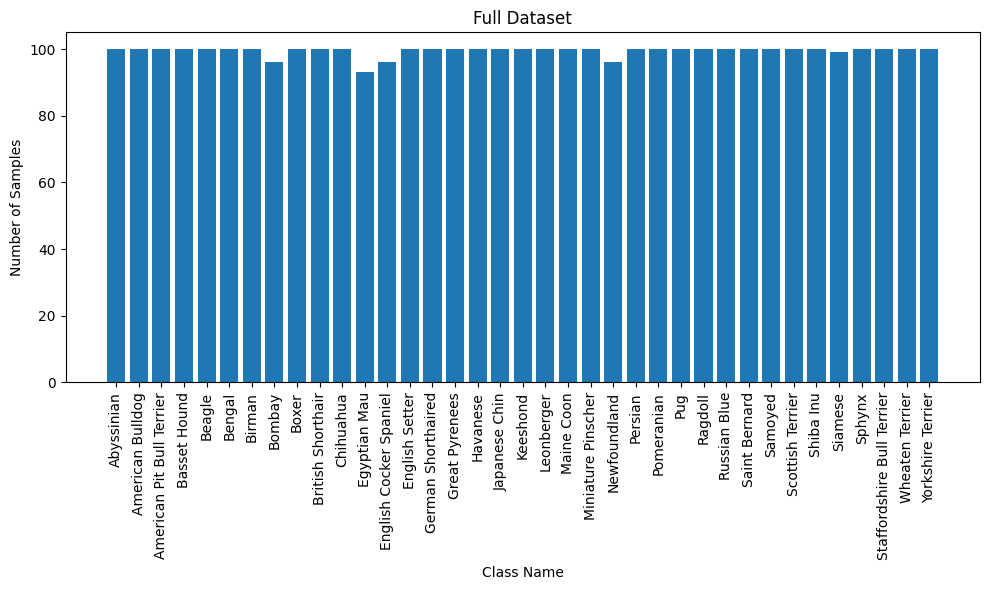

Number of samples: 1600
Extracting classes... (be patient)


100%|██████████| 1600/1600 [00:03<00:00, 437.46it/s]


Number of unique classes: 33


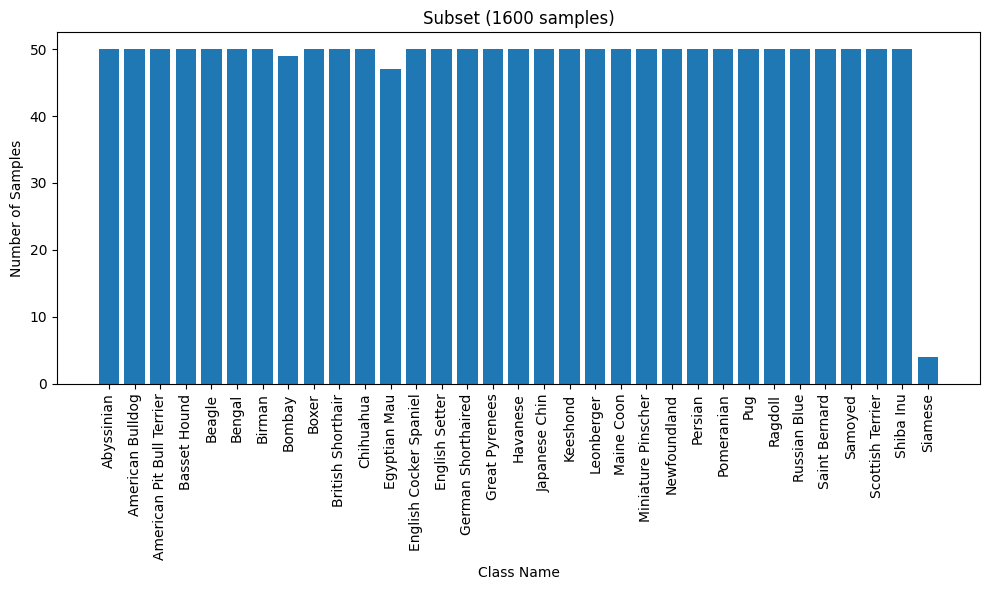

Number of samples: 1600
Extracting classes... (be patient)


100%|██████████| 1600/1600 [00:03<00:00, 439.01it/s]


Number of unique classes: 37


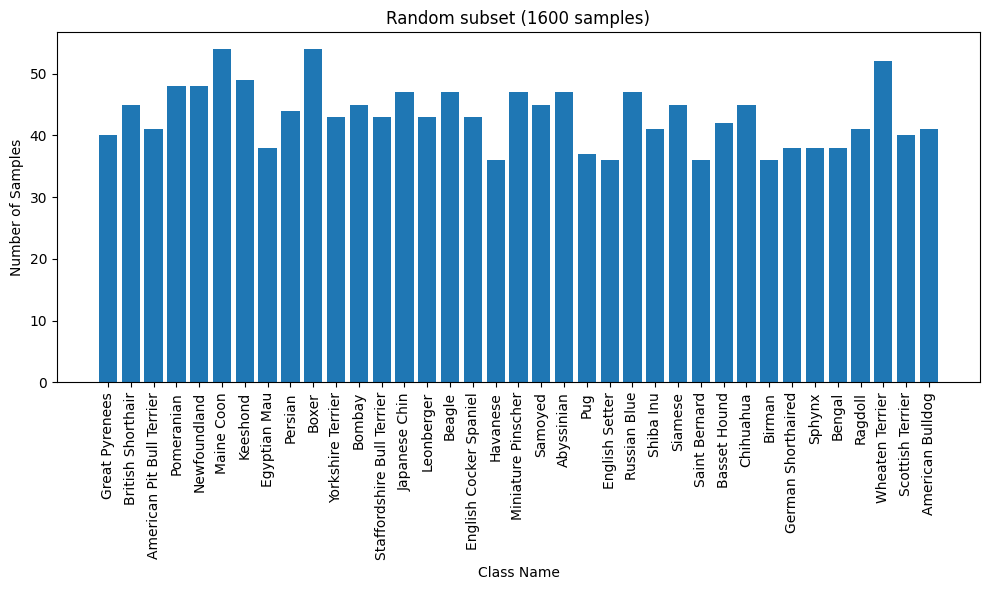

Creating balanced subset... (be patient)


100%|██████████| 3680/3680 [00:08<00:00, 446.40it/s]


Number of samples: 1600
Extracting classes... (be patient)


100%|██████████| 1600/1600 [00:03<00:00, 453.47it/s]


Number of unique classes: 37


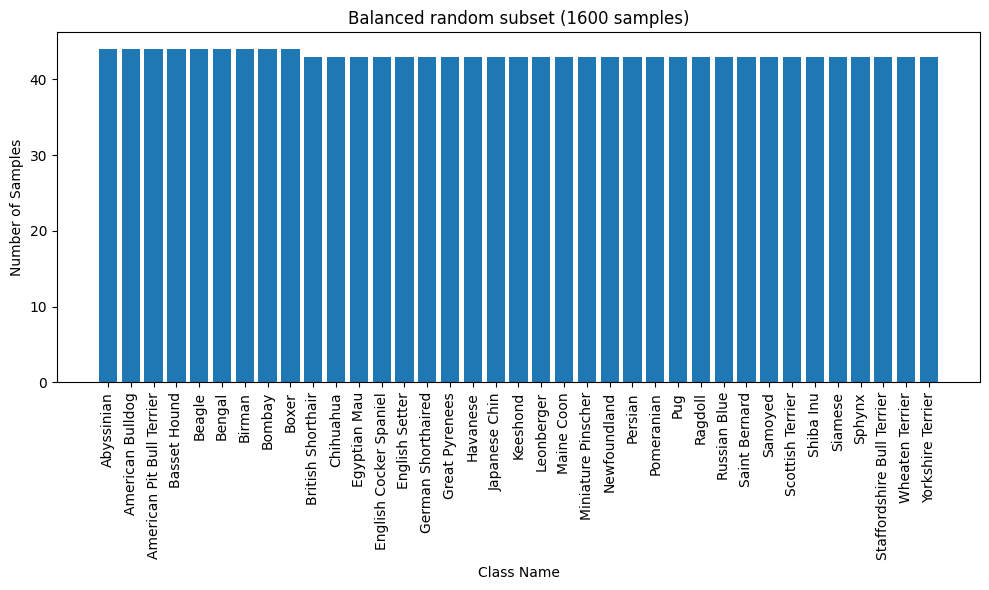

In [1]:
from determinism import Determinism
determinism = Determinism(seed=42).sow() 

import torch
from torch.utils.data import Dataset, Subset
import matplotlib.pyplot as plt
from collections import Counter
import random
from tqdm import tqdm

from datasets import load_dataset

def plot_class_histogram(dataset, title="Class Distribution"):
    print(f"Number of samples: {len(dataset)}")
    print("Extracting classes... (be patient)")
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset[i][1] for i in tqdm(dataset.indices)]
        class_to_idx = dataset.dataset.class_to_idx
    else:
        labels = [dataset[i][1] for i in tqdm(range(len(dataset)))]
        class_to_idx = dataset.class_to_idx

    label_counts = Counter(labels)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in label_counts.keys()]
    num_classes = len(set(labels))
    print(f"Number of unique classes: {num_classes}")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, label_counts.values())
    plt.xlabel("Class Name")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
dataset = load_dataset("trainval", transform=None)
plot_class_histogram(dataset, title="Full Dataset")

dataset_1600 = torch.utils.data.Subset(dataset, range(1600))
plot_class_histogram(dataset_1600, title="Subset (1600 samples)")

dataset_1600_random = torch.utils.data.Subset(dataset, random.sample(range(len(dataset)), 1600))
plot_class_histogram(dataset_1600_random, title="Random subset (1600 samples)")

def create_balanced_subset(dataset: Dataset, n: int) -> Subset:
    # Group sample indices by class label (slow for large datasets)
    class_to_indices = dict()
    print("Creating balanced subset... (be patient)")
    for i in tqdm(range(len(dataset))):
        label = dataset[i][1]
        if label not in class_to_indices:
            class_to_indices[label] = []
        class_to_indices[label].append(i)
    
    # Determine how many samples to draw from each class
    n_classes = len(class_to_indices)
    n_per_class = n // n_classes
    remainder = n - n_per_class * n_classes
    
    # Sample the desired number of indices per class
    # Distribute the remainder by giving +1 to the first 'remainder' classes
    balanced_indices = []
    for label, indices in class_to_indices.items():
        balanced_indices.extend(random.sample(indices, n_per_class + (label < remainder)))
    
    # Create the balanced subset
    balanced_subset = torch.utils.data.Subset(dataset, balanced_indices)
    return balanced_subset

dataset_1600_balanced = create_balanced_subset(dataset, 1600)
plot_class_histogram(dataset_1600_balanced, title="Balanced random subset (1600 samples)")